In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import scipy as sc
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [3]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

In [4]:
class BVP(object): 
    def __init__(self, f, g0=0, g1=0, x0=0, xend=1, alpha = 1, b = 1, c = 1,
                u_exact = None, u_exact_grad = None):
        self.u_exact = u_exact
        self.u_exact_grad = u_exact_grad
        self.f = f         # right hand side
        self.g0 = g0       # left boundary condition
        self.g1 = g1       # right boundary condition
        self.x0 = x0       # left boundary position 
        self.xend = xend   # right boundary position

        self.alpha = alpha
        self.b = b
        self.c = c

def generate_nodes(x0, xend, M):
    xs = np.sort(np.random.uniform(low = x0, high = xend, size=(M,)))
    xs[0] = x0
    xs[-1] = xend
    return xs

def generate_0dense(x0, xend, M):
    M0 = int(M/2)
    x_0 = np.linspace(x0, xend/4, M0)
    x_rest = np.linspace(xend/4, xend, M - M0 + 1)
    x = np.concatenate((x_0, x_rest[1:]))
    return x

def generate_exponential(x0, xend, M):
    x = np.linspace(-1, 1, M)
    y = np.exp(x)
    x = (y - np.min(y)) / (np.max(y) - np.min(y)) * (xend - x0) + x0
    return x

def get_hat(x, dir):
    if dir == "up":
        return (x - x[0])/(x[-1] - x[0])
    else:
        return (x[-1] - x)/(x[-1] - x[0])
    
def norm_err(U, u_exact, x, n, space="L2"):
    U_interp = sc.interpolate.interp1d(x, U)
    x_sub = np.linspace(x[0], x[-1], n)
    diff = U_interp(x_sub) - u_exact(x_sub)
    result = integrate.simpson(diff**2, x = x_sub)
    if space == "H1":
        result += integrate.simpson(np.gradient(diff, x_sub)**2, x = x_sub)
    return np.sqrt(result)


def get_F(f, x, n, fe=False):
    F = np.zeros(len(x)-2)

    for i in range(len(F)):
        for j in range(2):
            dir = "down"
            if not j:
                dir = "up"
            x_sub = np.linspace(x[i+j], x[i+j+1], n)
            if fe and x_sub[0] == 0:
                F[i] += (4*x_sub[-1]**(3/4))/7
            else:
                F[i] += integrate.simpson(f(x_sub)*get_hat(x_sub, dir),x=x_sub)
    return F


In [5]:
def solve_bvp(bvp: BVP, M=10, nodes = "linspace", fe=False, printA = False):
    x = np.linspace(bvp.x0, bvp.xend, M+1)      # Gridpoints, including boundary points
    if nodes == "random":
        x = generate_nodes(bvp.x0, bvp.xend, M+1)
    elif nodes == "0dense":
        x = generate_0dense(bvp.x0, bvp.xend, M+1)
    elif nodes == "exp":
        x = generate_exponential(bvp.x0, bvp.xend, M+1)

    hs = x[1:] - x[:-1]
    A1 = bvp.alpha*(np.diag(-1/hs[1:-1], k=-1) + np.diag(1/hs[:-1] + 1/hs[1:]) + np.diag(-1/hs[1:-1], k=1))
    A2 = bvp.b*tridiag(-1/2, 0, 1/2, M-1)
    A3 = bvp.c*(np.diag(hs[1:-1]/6, k=-1) + np.diag((hs[:-1] + hs[1:])/3) + np.diag(hs[1:-1]/6, k=1))
    
    A = A1 + A2 + A3
    if printA:
        print("A=\n", np.around(A,decimals=2, out=None))

    F = get_F(bvp.f,x,10*M, fe=fe)
    F[0] = F[0] + bvp.g0
    F[-1] = F[-1] + bvp.g1
    
    # Solve the system of linear equations
    Ui = sc.sparse.linalg.spsolve(A,F)

    # Include the boundary conditions:
    U = np.zeros(M+1)
    U[0] = bvp.g0
    U[1:-1] = Ui
    U[-1] = bvp.g1
    return x, U

A=
 [[ 20.07  -9.48   0.     0.     0.     0.     0.     0.     0.  ]
 [-10.48  20.07  -9.48   0.     0.     0.     0.     0.     0.  ]
 [  0.   -10.48  20.07  -9.48   0.     0.     0.     0.     0.  ]
 [  0.     0.   -10.48  20.07  -9.48   0.     0.     0.     0.  ]
 [  0.     0.     0.   -10.48  20.07  -9.48   0.     0.     0.  ]
 [  0.     0.     0.     0.   -10.48  20.07  -9.48   0.     0.  ]
 [  0.     0.     0.     0.     0.   -10.48  20.07  -9.48   0.  ]
 [  0.     0.     0.     0.     0.     0.   -10.48  20.07  -9.48]
 [  0.     0.     0.     0.     0.     0.     0.   -10.48  20.07]]


/Users/espen/Library/Python/3.8/lib/python/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


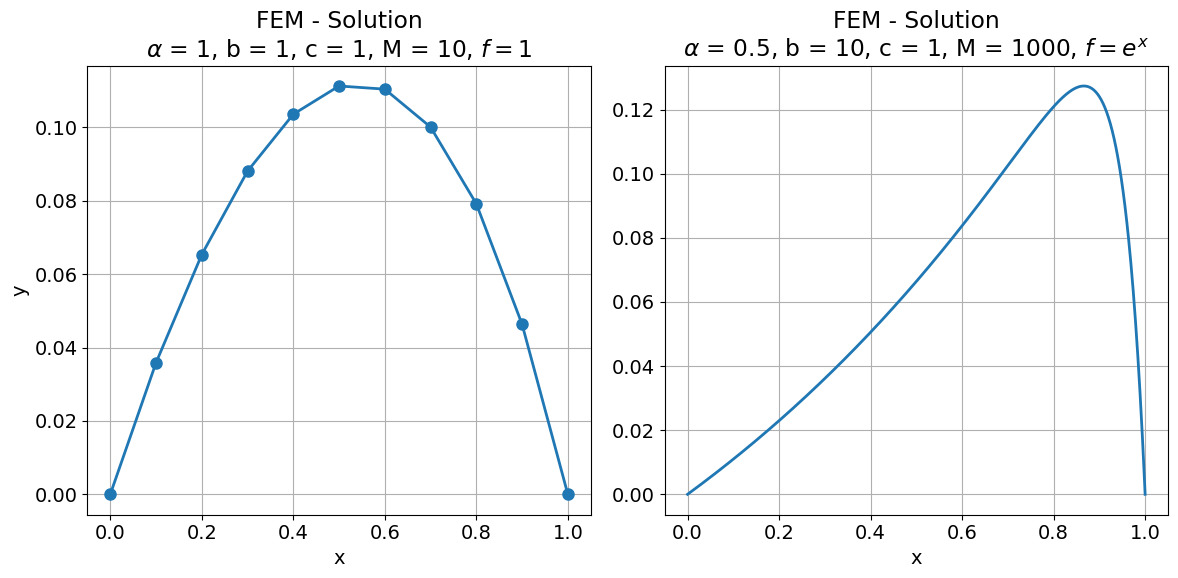

In [6]:
def getParam():
    return r"$\alpha$" + f" = {alpha}, b = {b}, c = {c}, M = {M}"

alpha = 1
b = 1
c = 1
M=10

def f_1(x):
    return np.ones_like(x)

bvp1 = BVP(f_1, 0, 0, 0, 1, alpha=alpha, b=b, c=c)
x1, U1 = solve_bvp(bvp1, M=M, printA = True)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(x1, U1, "o-")
ax[0].set_title("FEM - Solution\n" + getParam() + f", $f = 1$")
ax[0].set(xlabel='x', ylabel='y')

#-----------------------------

alpha = 0.5
b = 10
c = 1
M = 1000

def f_2(x):
    return np.exp(x)

bvp2 = BVP(f_2, 0, 0, 0, 1, alpha=alpha, b=b, c=c)
x2, U2 = solve_bvp(bvp2, M=M)


ax[1].plot(x2, U2)
ax[1].set_title("FEM - Solution\n" + getParam() + f", $f = e^x$")
ax[1].set(xlabel='x')
plt.tight_layout()
plt.savefig("Solutions_2a.png")


In [7]:
alpha = 1
b = 1
c = 1
x0 = 0
xend = 1
M = 100


def u(x):
    return np.sin(3*np.pi*x)
def f(x):
    return 9*np.pi**2*alpha*np.sin(3*np.pi*x)+3*b*np.pi*np.cos(3*np.pi*x)+c*np.sin(3*np.pi*x)

ex1 = BVP(f,g0=u(x0),g1=u(xend), alpha = alpha, b = b, c = c)

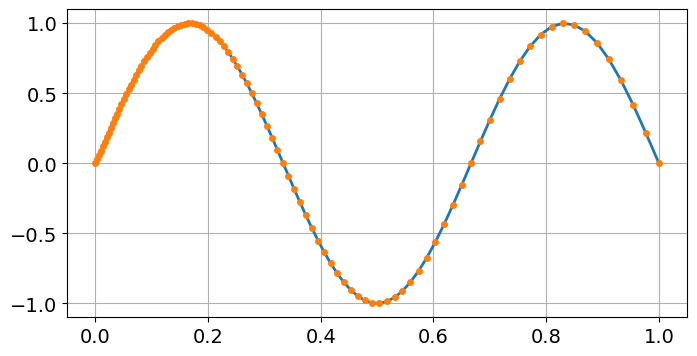

In [8]:
x, U = solve_bvp(ex1, M=M, nodes="exp")
plt.plot(x,U)
plt.plot(x,u(x),'.')

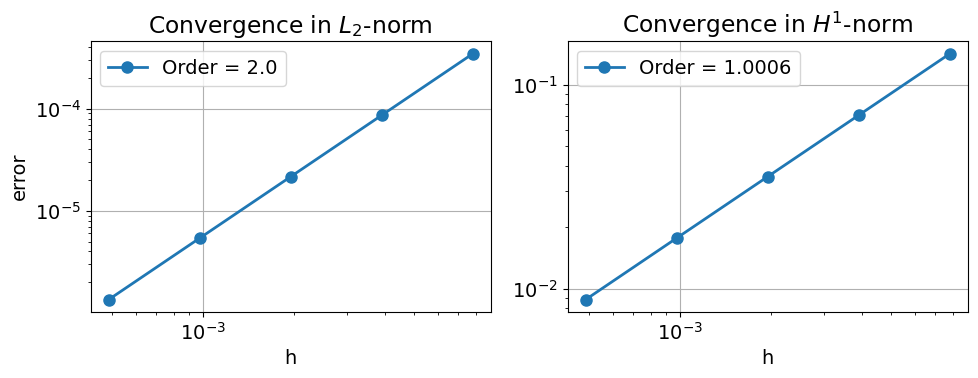

In [9]:
def convergence(bvp: BVP, u_exact, M0 = 128, K_max = 5, norm = "H1"):
    """
    Calculates errors for different values of M, i.e. different stepsizes.
    Returns array of stepsizes, errors and order of fitted curve in log-log.
    M0: number of intervals for first measurement
    K_max: number of times error will be measured (stepsize halved each time)
    """
    errs = np.zeros(K_max)
    hs = np.zeros(K_max)

    M = M0
    n = 1000*M*2**(K_max-1)
    
    for l in range(K_max):
        x, U = solve_bvp(ex1, M=M)

        hs[l] = (bvp.xend - bvp.x0)/M
        if norm == "H1":
            errs[l] = norm_err(U, u_exact, x, n, space="H1")
        elif norm == "L2":
            errs[l] = norm_err(U, u_exact, x, n)
        else:
            print("No such norm")
            return None      
        M *= 2

    order = np.polyfit(np.log(hs),np.log(errs),1)[0]
    return hs, errs, round(order, 4)

hs, Es, order = convergence(ex1, u, norm="H1")
hsL, EsL, orderL = convergence(ex1, u, norm="L2")

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].loglog(hsL,EsL, 'o-')
ax[0].set_title(f"Convergence in $L_2$-norm")
ax[0].legend([f"Order = {orderL}"])
ax[0].set(xlabel='h', ylabel='error')

ax[1].loglog(hs,Es, 'o-')
ax[1].set_title(f"Convergence in $H^1$-norm")
ax[1].legend([f"Order = {order}"])
ax[1].set(xlabel='h')

plt.tight_layout()
plt.savefig("Convergence2b.png")
plt.show()

## d)

In [10]:
def get_F_d(U_exact, grad_U_exact, x, n, alpha, b, c): 
    # U_exact = the exact solution (either w1 or w2)
    # x = nodes
    # n = num subintervals to sub-partition into
    
    F = np.zeros(len(x)-2)
    grad = grad_U_exact(x)
    func = U_exact(x)
    hs = x[1:] - x[:-1]
    for i in range(len(F)):
        for j in range(2):
            dir = "down"
            if not j: # j =0 -> True, j = 1 -> False
                dir = "up"
            x_sub = np.linspace(x[i+j], x[i+j+1], n) # subpartition of [x_(i-1), x_(i)], or [x_(i), x_(i+1)]
            
            # b,c-term
            F[i] += integrate.simpson(get_hat(x_sub, dir)*(b*grad_U_exact(x_sub) + c * U_exact(x_sub)),x=x_sub)

        # alpha-term
        # endring F[i] += alpha * (grad_U_exact(x[i]) - grad_U_exact(x[i+1]))
        F[i] += alpha * (grad[i+1] - grad[i+2])
        #F[i] += alpha * ((func[i+1]-func[i])/hs[i] + (func[i+1]-func[i+2])/hs[i+1])
    return F

def w1(x):
    y = np.zeros_like(x)
    split = len(x[x<=0.5])
    y[:split] = 2*x[:split]
    y[split:] = 2*(1-x[split:])
    return y

def grad_w1(x):
    func = np.full(len(x),2)
    split = len(x[x<=0.5])
    func[split:] = -2
    return func
    
def w2(x):
    return x - np.abs(x)**(2/3)

def grad_w2(x):
    y = np.zeros_like(x)
    y[1:] = 1 - (2/3) * x[1:]**(-1/3)
    y[0] = 1-(2/3)*(1.e-10)**(-1/3)
    return y

In [11]:
def solve_bvp_d(bvp: BVP, M=10, nodes = "linspace", fe=False, printA = False):
    x = np.linspace(bvp.x0, bvp.xend, M+1)      # Gridpoints, including boundary points

    hs = x[1:] - x[:-1]
    A1 = bvp.alpha*(np.diag(-1/hs[1:-1], k=-1) + np.diag(1/hs[:-1] + 1/hs[1:]) + np.diag(-1/hs[1:-1], k=1))
    A2 = bvp.b*tridiag(-1/2, 0, 1/2, M-1)
    A3 = bvp.c*(np.diag(hs[1:-1]/6, k=-1) + np.diag((hs[:-1] + hs[1:])/3) + np.diag(hs[1:-1]/6, k=1))
    
    A = A1 + A2 + A3
    if printA:
        print("A=\n", np.around(A,decimals=2, out=None))

    F = get_F_d(bvp.u_exact, bvp.u_exact_grad, x, 1500000, bvp.alpha, bvp.b, bvp.c)
    
    F[0] = F[0] + bvp.g0
    F[-1] = F[-1] + bvp.g1
    
    # Solve the system of linear equations
    Ui = sc.sparse.linalg.spsolve(A,F)

    # Include the boundary conditions:
    U = np.zeros(M+1)
    U[0] = bvp.g0
    U[1:-1] = Ui
    U[-1] = bvp.g1
    return x, U

In [12]:
def convergence_d(bvp_1: BVP, bvp_2: BVP, u_exact_1, u_exact_2, M0 = 100, K_max = 5):
    """
    Calculates errors for different values of M, i.e. different stepsizes.
    Returns array of stepsizes, errors and order of fitted curve in log-log.
    M0: number of intervals for first measurement
    K_max: number of times error will be measured (stepsize halved each time)
    """
    
    #expected_time = 7.2*(M0/100)**2*2**((K_max)*2)
    #print(expected_time)
    
    err_1_H = np.zeros(K_max)
    err_1_L = np.zeros(K_max)
    hs_1 = np.zeros(K_max)
    err_2_H = np.zeros(K_max)
    err_2_L = np.zeros(K_max)
    hs_2 = np.zeros(K_max)

    M = M0
    n = 500000
    
    j = 0
    for l in range(K_max):
        x_1, U_1 = solve_bvp_d(bvp_1, M=M)
        j += 1
        print(100*(j)/(K_max*2), "%", end="\r")
        x_2, U_2 = solve_bvp_d(bvp_2, M=M)
        j += 1
        print(100*(j)/(K_max*2), "%", end="\r")

        hs_1[l] = (bvp_1.xend - bvp_1.x0)/M
        hs_2[l] = (bvp_2.xend - bvp_2.x0)/M
        err_1_H[l] = norm_err(U_1, u_exact_1, x_1, n, space="H1")
        err_1_L[l] = norm_err(U_1, u_exact_1, x_1, n, space="L2")
        err_2_H[l] = norm_err(U_2, u_exact_2, x_2, n, space="H1")
        err_2_L[l] = norm_err(U_2, u_exact_2, x_2, n, space="L2")
        
        M = 2*M

    order_1_H = np.polyfit(np.log(hs_1),np.log(err_1_H),1)[0]
    order_1_L = np.polyfit(np.log(hs_1),np.log(err_1_L),1)[0]
    order_2_H = np.polyfit(np.log(hs_2),np.log(err_2_H),1)[0]
    order_2_L = np.polyfit(np.log(hs_2),np.log(err_2_L),1)[0]
    
    return hs_1, hs_2, err_1_H, err_1_L, err_2_H, err_2_L, round(order_1_H, 4), round(order_1_L, 4), round(order_2_H, 4), round(order_2_L, 4)

In [13]:
bvp_d_w1 = BVP(None, 0, 0, 0, 1, u_exact=w1, u_exact_grad=grad_w1)
bvp_d_w2 = BVP(None, 0, 0, 0, 1, u_exact=w2, u_exact_grad=grad_w2)

In [14]:
hs_1, hs_2, err_1_H, err_1_L, err_2_H, err_2_L, order_1_H, order_1_L, order_2_H, order_2_L = convergence_d(bvp_d_w1, bvp_d_w2, w1, w2, M0 = 50, K_max = 4)

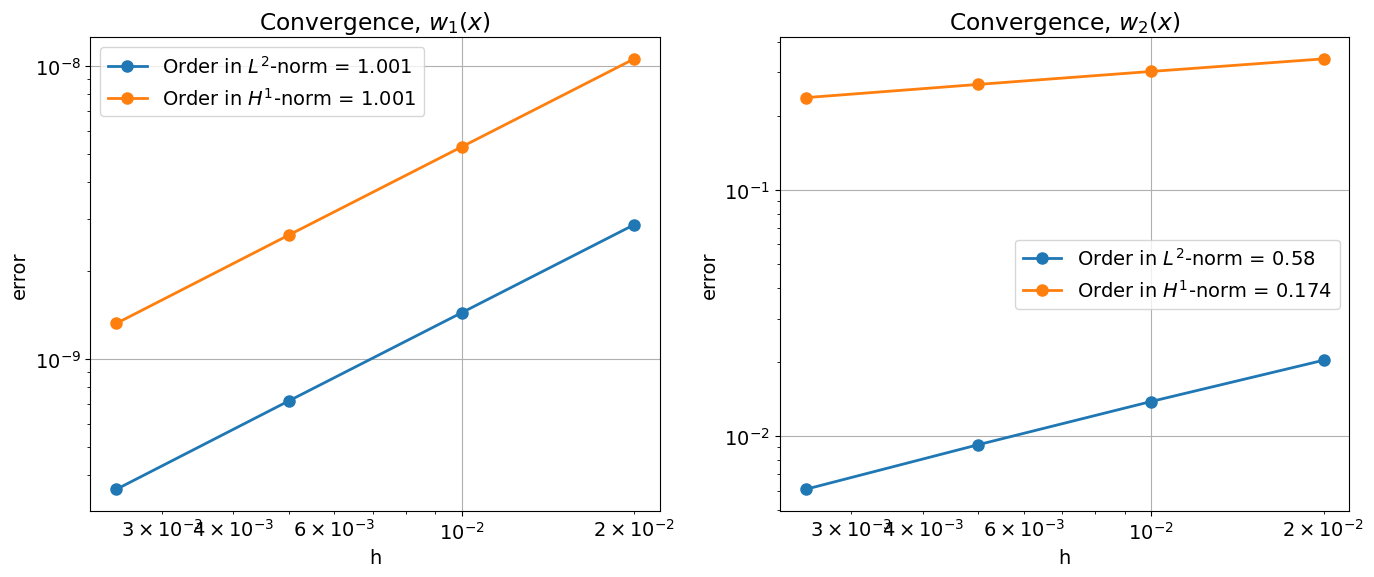

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

order_1_H = round(np.polyfit(np.log(hs_1),np.log(err_1_H),1)[0],3)
order_1_L = round(np.polyfit(np.log(hs_1),np.log(err_1_L),1)[0],3)
order_2_H = round(np.polyfit(np.log(hs_2),np.log(err_2_H),1)[0],3)
order_2_L = round(np.polyfit(np.log(hs_2),np.log(err_2_L),1)[0],3)

ax[0].loglog(hs_1,err_1_L, 'o-')
ax[0].loglog(hs_1,err_1_H, 'o-')
ax[0].set_title(r"Convergence, $w_1(x)$")
ax[0].legend([fr"Order in $L^2$-norm = {order_1_L}", f"Order in $H^1$-norm = {order_1_H}"])
ax[0].set(xlabel='h', ylabel='error')

ax[1].loglog(hs_2,err_2_L, 'o-')
ax[1].loglog(hs_2,err_2_H, 'o-')
ax[1].set_title(r"Convergence, $w_2(x)$")
ax[1].legend([fr"Order in $L^2$-norm = {order_2_L}", f"Order in $H^1$-norm = {order_2_H}"])
ax[1].set(xlabel='h', ylabel='error')

plt.tight_layout()
plt.savefig("Convergence2d.png")
plt.show()

## e)

126.0


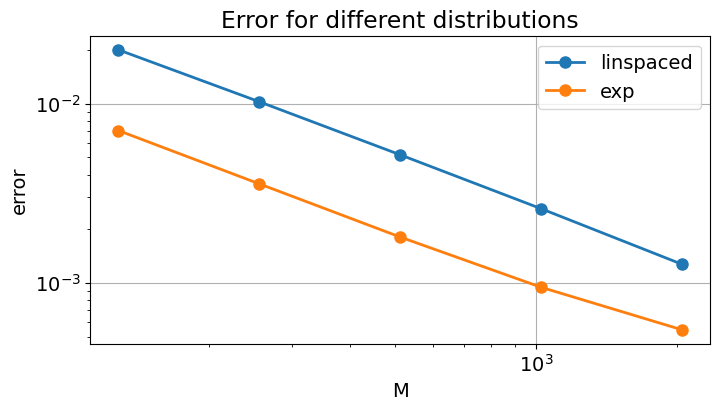

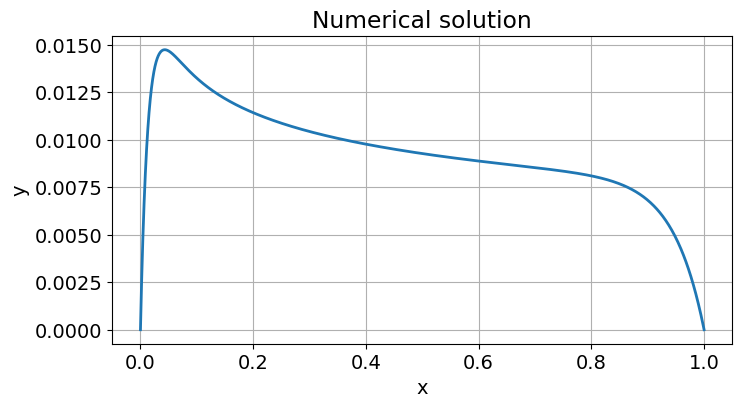

In [16]:
def convergence2(bvp: BVP, M_exact = 2**13 , M0 = 2**6, K = 5):
    """
    Calculates errors for different values of M, i.e. different stepsizes.
    Returns array of stepsizes, errors and order of fitted curve in log-log.
    M0: number of intervals for first measurement
    K_max: number of times error will be measured (stepsize halved each time)
    """
    x, U_ex = solve_bvp(bvp, M=M_exact, fe=True)
    U_ex_interp = sc.interpolate.interp1d(x, U_ex, kind="linear")

    nodetype = ["linspaced", "exp"]
    n = 1000*M0*2**(K-1)
    for i, nodes in enumerate(nodetype):
        errs = np.zeros(K)
        ms = np.zeros(K)
        M = M0
        for k in range(K):
            M *= 2
            x, U = solve_bvp(bvp, M=M, nodes = nodes, fe=True)
            errs[k] = norm_err(U, U_ex_interp, x, n, space="H1")
            ms[k] = M
            
        plt.loglog(ms, errs,"o-")

    plt.xlabel("M")
    plt.ylabel("error")
    plt.legend(nodetype)
    plt.title("Error for different distributions")
    plt.savefig("Convergence2e.png")
    plt.show()

    plt.plot(x, U)
    plt.title("Numerical solution")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.savefig("Solution_2e.png")
    plt.show()

def f_e(x):
    return x**(-1/4)

alpha = 0.1
b = -5
c = (abs(b)**2)/(2*alpha) + 1
print(c)

bvp_e = BVP(f_e,g0=0,g1=0, alpha = alpha, b = b, c = c)
convergence2(bvp_e)

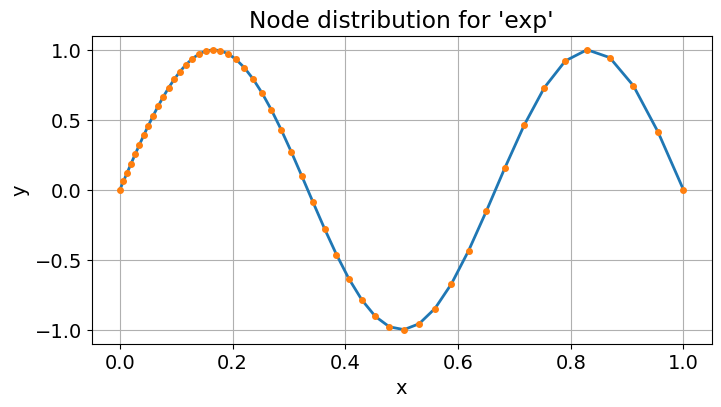

In [17]:
alpha = 1
b = 1
c = 1
x0 = 0
xend = 1
M = 50

def u(x):
    return np.sin(3*np.pi*x)
def f(x):
    return 9*np.pi**2*alpha*np.sin(3*np.pi*x)+3*b*np.pi*np.cos(3*np.pi*x)+c*np.sin(3*np.pi*x)

ex1 = BVP(f,g0=u(x0),g1=u(xend), alpha = alpha, b = b, c = c)

x, U = solve_bvp(ex1, M=M, nodes="exp")
plt.plot(x,U)
plt.plot(x,u(x),'.')
plt.title("Node distribution for 'exp'")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("Node_distr.png")